In [1]:
import pandas as pd
import os
import math
from math import exp, ceil, floor
import numpy as np
import cx_Oracle
from config import oracle_wfm_key
import time
import datetime as dt
from sqlalchemy import create_engine
from sqlalchemy.engine import URL
from sqlalchemy.types import String
from tqdm import tqdm
import itertools
import databases as db
import pyworkforce
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
ods = db.oracle('cco_wfm',oracle_wfm_key)
verint  = db.ssms()
service = ['Bend/Cable Consumer Sales','OB_QCB Bend/Cable Sales','Cable Specialist','OB_OCB_Cable_Con_Spec',
           'Financial Services Res','Financial Services Bus',
           'Wireline Sales and Service','Wireline Service QCB','Wireline Consumer Specialist','Wireline Consumer Triage','Wireline Retention QCB',
           'Wireline Repair Residential','Wireline Repair Business','Cable Repair Business', 'Cable Repair Residential']
start = '2022-04-01 00:00:00.000'
end = '2023-06-30 23:45:00.000'
appended_data = []
for name in service:
    new_query = f'''SELECT 
                        [Queue],
                        [DateTime],
                        [Actual_CV],
                        [Forecasted_CV],
                        [Actual_AHT],
                        [Forecasted_AHT]                                             
                    FROM [BPMAINDB].[dbo].[V_AdHoc_PerformanceStatistics]
                    WHERE ([Queue] = '{name}') AND ([DateTime] BETWEEN '{start}' AND '{end}')
                    AND ([UserName] = 'satverintwrkoptmgmt')'''
    data = pd.read_sql(new_query, verint)
    appended_data.append(data)
appended_data = pd.concat(appended_data)

In [3]:
team_dict = {'Bend/Cable Consumer Sales' : 'Cable_Sales','OB_QCB Bend/Cable Sales' : 'Cable_Sales','Cable Specialist' : 'Cable_Retention','OB_OCB_Cable_Con_Spec' : 'Cable_Retention',
             'Financial Services Res' : 'Residential_FS','Financial Services Bus' : 'Commercial_FS',
             'Wireline Sales and Service' : 'Wireline_Sales','Wireline Service QCB' : 'Wireline_Sales',
             'Wireline Consumer Specialist' : 'Wireline_Retention','Wireline Consumer Triage' : 'Wireline_Retention','Wireline Retention QCB' : 'Wireline_Retention',
             'Wireline Repair Residential': 'Repair_Residential', 'Wireline Repair Business': 'Repair_Commercial',
             'Cable Repair Residential': 'Repair_Residential','Cable Repair Residential': 'Repair_Commercial'}
appended_data['Team'] = appended_data['Queue'].map(team_dict)
appended_data = appended_data.reindex(columns=['Team'] + list(appended_data.columns[:-1]))
appended_data.tail(3)

Team                     Queue            DateTime  \
43773  Repair_Commercial  Cable Repair Residential 2023-06-30 23:15:00   
43774  Repair_Commercial  Cable Repair Residential 2023-06-30 23:30:00   
43775  Repair_Commercial  Cable Repair Residential 2023-06-30 23:45:00   

       Actual_CV  Forecasted_CV  Actual_AHT  Forecasted_AHT  
43773        6.0            2.0      1482.0          1043.0  
43774        7.0            2.0       667.0          1197.0  
43775        7.0            1.0       667.0          1160.0

In [4]:
appended_data['Actual_Workload'] = appended_data['Actual_AHT'] * appended_data['Actual_CV']
appended_data['Actual_Workload'] = appended_data['Actual_Workload'].replace(0, np.nan)
appended_data['Forecasted_Workload'] = appended_data['Forecasted_AHT'] * appended_data['Forecasted_CV']
appended_data['Forecasted_Workload'] = appended_data['Forecasted_Workload'].replace(0, np.nan)

In [5]:
team = ['Commercial_Billing','Commercial_Sales','Cable_Sales','Cable_Retention','Residential_FS','Commercial_FS',
        'Wireline_Sales','Wireline_Retention','Repair_Residential', 'Repair_Commercial']
dfs = []
for t in team:
    team_group = appended_data.loc[(appended_data['Team']  == t)]
    actual_cv = team_group.groupby(['Team','DateTime'])['Actual_CV'].sum()
    actual_cv = actual_cv.reset_index()
    actual_cv.set_index('DateTime', inplace=True) # set the index to the 'DateTime' column
    actual_cv = actual_cv.resample('30 min').sum() # remove the 'on' parameter
    actual_cv.reset_index(inplace=True)
    actual_cv.set_index('DateTime', inplace=True)
    
    forecasted_cv = team_group.groupby(['Team','DateTime'])['Forecasted_CV'].sum()
    forecasted_cv = forecasted_cv.reset_index()
    forecasted_cv.set_index('DateTime', inplace=True) # set the index to the 'DateTime' column
    forecasted_cv = forecasted_cv.resample('30 min').sum() # remove the 'on' parameter
    forecasted_cv.reset_index(inplace=True)
    forecasted_cv.set_index('DateTime', inplace=True)
    
    grouped_aht = team_group.groupby(['Team','DateTime'])['Actual_Workload'].sum()
    grouped_aht = grouped_aht.reset_index()
    grouped_aht['Actual_Workload'] = grouped_aht['Actual_Workload'].replace(0, np.nan)
    grouped_aht.set_index('DateTime', inplace=True) # set the index to the 'DateTime' column
    grouped_aht = grouped_aht.resample('30 min').sum() # remove the 'on' parameter
    grouped_cv = team_group.groupby(['Team','DateTime'])['Actual_CV'].sum()
    grouped_cv = grouped_cv.reset_index()
    grouped_cv.set_index('DateTime', inplace=True) # set the index to the 'DateTime' column
    grouped_cv = grouped_cv.resample('30 min').sum() # remove the 'on' parameter
    actual_aht = grouped_aht.merge(grouped_cv, on='DateTime', how='left')
    actual_aht['Actual_AHT'] = actual_aht['Actual_Workload'] / actual_aht['Actual_CV']
    actual_aht = actual_aht.drop(columns=['Actual_Workload','Actual_CV'])
    actual_aht.reset_index(inplace=True)
    actual_aht.set_index('DateTime', inplace=True)
    actual_aht['Actual_AHT'] = actual_aht['Actual_AHT'].fillna(0)
    actual_aht['Actual_AHT'] = round(actual_aht['Actual_AHT'])
    
    grouped_faht = team_group.groupby(['Team','DateTime'])['Forecasted_Workload'].sum()
    grouped_faht = grouped_faht.reset_index()
    grouped_faht['Forecasted_Workload'] = grouped_faht['Forecasted_Workload'].replace(0, np.nan)
    grouped_faht.set_index('DateTime', inplace=True) # set the index to the 'DateTime' column
    grouped_faht = grouped_faht.resample('30 min').sum() # remove the 'on' parameter
    grouped_fcv = team_group.groupby(['Team','DateTime'])['Forecasted_CV'].sum()
    grouped_fcv = grouped_fcv.reset_index()
    grouped_fcv.set_index('DateTime', inplace=True) # set the index to the 'DateTime' column
    grouped_fcv = grouped_fcv.resample('30 min').sum() # remove the 'on' parameter
    forecasted_aht = grouped_faht.merge(grouped_fcv, on='DateTime', how='left')
    forecasted_aht['Forecasted_AHT'] = forecasted_aht['Forecasted_Workload'] / forecasted_aht['Forecasted_CV']
    forecasted_aht = forecasted_aht.drop(columns=['Forecasted_Workload','Forecasted_CV'])
    forecasted_aht.reset_index(inplace=True)
    forecasted_aht.set_index('DateTime', inplace=True)
    forecasted_aht['Forecasted_AHT'] = forecasted_aht['Forecasted_AHT'].fillna(0)
    forecasted_aht['Forecasted_AHT'] = round(forecasted_aht['Forecasted_AHT'])
    
    cv = actual_cv.merge(forecasted_cv, on=['DateTime'], how='left')
    aht = actual_aht.merge(forecasted_aht, on=['DateTime'], how='left')
    table = cv.merge(aht, on=['DateTime'], how='left')
    table['Team'] = t
    table = table.reindex(columns=['Team'] + list(table.columns[:-1]))
    dfs.append(table)

call_data = pd.concat(dfs)

In [6]:
call_data.reset_index(inplace=True)
call_data['Date'] = call_data['DateTime'].dt.date
call_data['Time'] = call_data['DateTime'].dt.time
call_data = call_data.drop('DateTime', axis=1)
call_data['Time_Interval'] = '00:30'
call_data = call_data[['Team', 'Date', 'Time', 'Time_Interval', 'Actual_CV', 'Forecasted_CV', 'Actual_AHT', 'Forecasted_AHT']]
call_data.to_csv('call_data.csv')
call_data.head()

Team        Date      Time Time_Interval  Actual_CV  Forecasted_CV  \
0  Cable_Sales  2022-04-01  00:00:00         00:30        0.0            0.0   
1  Cable_Sales  2022-04-01  00:30:00         00:30        0.0            0.0   
2  Cable_Sales  2022-04-01  01:00:00         00:30        0.0            0.0   
3  Cable_Sales  2022-04-01  01:30:00         00:30        0.0            0.0   
4  Cable_Sales  2022-04-01  02:00:00         00:30        0.0            0.0   

   Actual_AHT  Forecasted_AHT  
0         0.0             0.0  
1         0.0             0.0  
2         0.0             0.0  
3         0.0             0.0  
4         0.0             0.0

## Erlang Class

In [7]:
class ErlangC:
    """
    Computes the number of positions required to attend a number of transactions in a
    queue system based on erlangc.rst. Implementation inspired on:
    https://lucidmanager.org/data-science/call-centre-workforce-planning-erlang-c-in-r/
    Parameters
    ----------
    transactions: float,
        The number of total transactions that comes in an interval.
    aht: float,
        Average handling time of a transaction (minutes).
    asa: float,
        The required average speed of answer (minutes).
    interval: int,
        Interval length (minutes) where the transactions come in
    shrinkage: float,
        Percentage of time that an operator unit is not available.
    """

    def __init__(self, transactions: float, aht: float, asa: float,
                 interval: int, shrinkage=0.0,
                 **kwargs):

        if transactions <= 0:
            raise ValueError("transactions can't be smaller or equals than 0")

        if aht <= 0:
            raise ValueError("aht can't be smaller or equals than 0")

        if asa <= 0:
            raise ValueError("asa can't be smaller or equals than 0")

        if interval <= 0:
            raise ValueError("interval can't be smaller or equals than 0")

        if shrinkage < 0 or shrinkage >= 1:
            raise ValueError("shrinkage must be between in the interval [0,1)")

        self.n_transactions = transactions
        self.aht = aht / 60  # Convert aht from seconds to minutes
        self.interval = interval
        self.asa = asa
        self.intensity = (self.n_transactions / self.interval) * self.aht
        self.shrinkage = shrinkage


    def waiting_probability(self, positions: int, scale_positions: bool = False):
        """
        Returns the probability of waiting in the queue
        Parameters
        ----------
        positions: int,
            The number of positions to attend the transactions.
        scale_positions: bool, default=False
            Set it to True if the positions were calculated using shrinkage.
        """

        if scale_positions:
            productive_positions = floor((1 - self.shrinkage) * positions)
        else:
            productive_positions = positions

        erlang_b_inverse = 1
        for position in range(1, productive_positions + 1):
            erlang_b_inverse = 1 + (erlang_b_inverse * position / self.intensity)

        erlang_b = 1 / erlang_b_inverse
        return productive_positions * erlang_b / (productive_positions - self.intensity * (1 - erlang_b))

    def service_level(self, positions: int, scale_positions: bool = False):
        """
        Returns the expected service level given a number of positions
        Parameters
        ----------
        positions: int,
            The number of positions attending.
        scale_positions: bool, default = False
            Set it to True if the positions were calculated using shrinkage.
        """
        if scale_positions:
            productive_positions = floor((1 - self.shrinkage) * positions)
        else:
            productive_positions = positions

        probability_wait = self.waiting_probability(productive_positions, scale_positions=False)
        exponential = exp(-(productive_positions - self.intensity) * (self.asa / self.aht))
        return max(0, 1 - (probability_wait * exponential))

    def achieved_occupancy(self, positions: int, scale_positions: bool = False):
        """
        Returns the expected occupancy of positions
        Parameters
        ----------
        positions: int,
            The number of raw positions
        scale_positions: bool, default=False
            Set it to True if the positions were calculated using shrinkage.
        """
        if scale_positions:
            productive_positions = floor((1 - self.shrinkage) * positions)
        else:
            productive_positions = positions

        return self.intensity / productive_positions

    def required_positions(self, service_level: float, max_occupancy: float = 1.0):
        """
        Computes the requirements using erlangc.rst
        Parameters
        ----------
        service_level: float,
            Target service level
        max_occupancy: float,
            The maximum fraction of time that a transaction can occupy a position
        Returns
        -------
        raw_positions: int,
            The required positions assuming shrinkage = 0
        positions: int,
            The number of positions needed to ensure the required service level
        service_level: float,
            The fraction of transactions that are expected to be assigned to a position,
            before the asa time
        occupancy: float,
            The expected occupancy of positions
        waiting_probability: float,
            The probability of a transaction waiting in the queue
        """

        if service_level < 0 or service_level > 1:
            raise ValueError("service_level must be between 0 and 1")

        if max_occupancy < 0 or max_occupancy > 1:
            raise ValueError("max_occupancy must be between 0 and 1")

        positions = round(self.intensity + 1)
        achieved_service_level = self.service_level(positions, scale_positions=False)
        while achieved_service_level < service_level:
            positions += 1
            achieved_service_level = self.service_level(positions, scale_positions=False)

        achieved_occupancy = self.achieved_occupancy(positions, scale_positions=False)

        raw_positions = ceil(positions)

        if achieved_occupancy > max_occupancy:
            raw_positions = ceil(self.intensity / max_occupancy)
            achieved_occupancy = self.achieved_occupancy(raw_positions)
            achieved_service_level = self.service_level(raw_positions)

        waiting_probability = self.waiting_probability(positions=raw_positions)
        positions = ceil(raw_positions / (1 - self.shrinkage))

        return {"raw_positions": raw_positions,
                "positions": positions,
                "service_level": achieved_service_level,
                "occupancy": achieved_occupancy,
                "waiting_probability": waiting_probability}

## Service Level Testing

In [8]:
team_settings = {
    'Cable_Sales': [(0.65, 0.05, 30, 30), (0.60, 0.05, 30, 30), (0.55, 0.05, 30, 30), (0.50, 0.05, 30, 30), (0.60, 0.05, 30, 45), (0.60, 0.05, 30, 60)],
    'Cable_Retention': [(0.65, 0.05, 30, 30), (0.60, 0.05, 30, 30), (0.55, 0.05, 30, 30), (0.50, 0.05, 30, 30), (0.60, 0.05, 30, 45), (0.60, 0.05, 30, 60)],
    'Residential_FS': [(0.65, 0.05, 30, 30), (0.60, 0.05, 30, 30), (0.55, 0.05, 30, 30), (0.50, 0.05, 30, 30), (0.60, 0.05, 30, 45), (0.60, 0.05, 30, 60)],
    'Commercial_FS': [(0.65, 0.05, 30, 30), (0.60, 0.05, 30, 30), (0.55, 0.05, 30, 30), (0.50, 0.05, 30, 30), (0.60, 0.05, 30, 45), (0.60, 0.05, 30, 60)],
    'Wireline_Sales': [(0.65, 0.05, 30, 30), (0.60, 0.05, 30, 30), (0.55, 0.05, 30, 30), (0.50, 0.05, 30, 30), (0.60, 0.05, 30, 45), (0.60, 0.05, 30, 60)],
    'Wireline_Retention': [(0.65, 0.05, 30, 30), (0.60, 0.05, 30, 30), (0.55, 0.05, 30, 30), (0.50, 0.05, 30, 30), (0.60, 0.05, 30, 45), (0.60, 0.05, 30, 60)],
    'Repair_Residential': [(0.65, 0.05, 30, 30), (0.60, 0.05, 30, 30), (0.55, 0.05, 30, 30), (0.50, 0.05, 30, 30), (0.60, 0.05, 30, 45), (0.60, 0.05, 30, 60)],
    'Repair_Commercial': [(0.65, 0.05, 30, 30), (0.60, 0.05, 30, 30), (0.55, 0.05, 30, 30), (0.50, 0.05, 30, 30), (0.60, 0.05, 30, 45), (0.60, 0.05, 30, 60)],
}


### Base Erlang Function

In [9]:
def process_data(team_settings, team, interval_df, data_type):
    results = []

    for team_info in team_settings:
        service_level_percent, shrinkage, reporting_period, service_level_time = team_info

        for _, row in interval_df.iterrows():
            transactions = row[f'{data_type}_CV']
            aht = row[f'{data_type}_AHT']
            interval = reporting_period
            asa = service_level_time / 60

            if transactions > 0 and aht > 0:
                erlang = ErlangC(transactions=transactions, aht=aht, interval=interval, asa=asa, shrinkage=shrinkage)
                positions_requirements = erlang.required_positions(service_level=service_level_percent)

                result = {
                    'Team': team,
                    'Date': row['Date'],
                    'Time': row['Time'],
                    'Time_Interval': row['Time_Interval'],
                    'Service_Level': service_level_percent,
                    'Service_Level_Time': service_level_time,
                    f'{data_type}_CV': transactions,
                    f'{data_type}_AHT': aht,
                    f'{data_type}_Required_FTE': positions_requirements['positions'],
                    f'{data_type}_Raw_FTE': positions_requirements['raw_positions'],
                    f'Service_Level_{data_type}': positions_requirements['service_level'],
                    f'Occupancy_{data_type}': positions_requirements['occupancy'],
                    f'Waiting_Probablility_{data_type}': positions_requirements['waiting_probability'],
                }
                results.append(result)

    return pd.DataFrame(results)

# Adjusted call
results = []
for team, settings in team_settings.items():
    team_df = call_data[call_data['Team'] == team]
    actual_df = process_data(settings, team, team_df, 'Actual')
    forecasted_df = process_data(settings, team, team_df, 'Forecasted')
    result_df = actual_df.merge(forecasted_df, on=['Team', 'Service_Level', 'Service_Level_Time', 'Date', 'Time', 'Time_Interval'], how='outer')
    
    if not result_df.empty:
        results.append(result_df)

final_results = pd.concat(results, ignore_index=True)
final_results.fillna(0, inplace=True)
final_results['Date'] = pd.to_datetime(final_results['Date'], format='%Y-%m-%d')
final_results = final_results.sort_values(by=['Team', 'Service_Level', 'Service_Level_Time', 'Date', 'Time'])


In [10]:
final_results[['Team','Date','Time','Service_Level','Service_Level_Time','Actual_Required_FTE','Service_Level_Actual','Occupancy_Actual','Waiting_Probablility_Actual']].head(25)

Team       Date      Time  Service_Level  \
81834  Cable_Retention 2022-04-01  08:00:00            0.5   
81835  Cable_Retention 2022-04-01  08:30:00            0.5   
81836  Cable_Retention 2022-04-01  09:00:00            0.5   
81837  Cable_Retention 2022-04-01  09:30:00            0.5   
81838  Cable_Retention 2022-04-01  10:00:00            0.5   
81839  Cable_Retention 2022-04-01  10:30:00            0.5   
81840  Cable_Retention 2022-04-01  11:00:00            0.5   
81841  Cable_Retention 2022-04-01  11:30:00            0.5   
81842  Cable_Retention 2022-04-01  12:00:00            0.5   
81843  Cable_Retention 2022-04-01  12:30:00            0.5   
81844  Cable_Retention 2022-04-01  13:00:00            0.5   
81845  Cable_Retention 2022-04-01  13:30:00            0.5   
81846  Cable_Retention 2022-04-01  14:00:00            0.5   
81847  Cable_Retention 2022-04-01  14:30:00            0.5   
81848  Cable_Retention 2022-04-01  15:00:00            0.5   
81849  Cable_Retention 2022-04-01  15:30:00            0.5   
81850  Cable_Retention 2022-04-01  16:00:00            0.5   
81851  Cable_Retention 2022-04-01  16:30:00            0.5   
81852  Cable_Retention 2022-04-01  17:00:00            0.5   
81853  Cable_Retention 2022-04-01  17:30:00            0.5   
81854  Cable_Retention 2022-04-01  18:00:00            0.5   
81855  Cable_Retention 2022-04-01  18:30:00            0.5   
81856  Cable_Retention 2022-04-01  19:00:00            0.5   
81857  Cable_Retention 2022-04-01  19:30:00            0.5   
81858  Cable_Retention 2022-04-02  09:00:00            0.5   

       Service_Level_Time  Actual_Required_FTE  Service_Level_Actual  \
81834                  30                  2.0              0.686244   
81835                  30                  5.0              0.782605   
81836                  30                  4.0              0.739298   
81837                  30                  6.0              0.557152   
81838                  30                  9.0              0.590358   
81839                  30                 12.0              0.597236   
81840                  30                 14.0              0.673940   
81841                  30                 12.0              0.529314   
81842                  30                  9.0              0.514559   
81843                  30                 11.0              0.689475   
81844                  30                 10.0              0.527687   
81845                  30                 11.0              0.561666   
81846                  30                 10.0              0.529006   
81847                  30                 12.0              0.653400   
81848                  30                  9.0              0.628302   
81849                  30                 12.0              0.617530   
81850                  30                 11.0              0.559981   
81851                  30                 11.0              0.552655   
81852                  30                 11.0              0.573721   
81853                  30                 10.0              0.649766   
81854                  30                  6.0              0.566024   
81855                  30                  9.0              0.655813   
81856                  30                  9.0              0.725772   
81857                  30                  4.0              0.806876   
81858                  30                  4.0              0.792926   

       Occupancy_Actual  Waiting_Probablility_Actual  
81834          0.345000                     0.345000  
81835          0.560000                     0.238265  
81836          0.548148                     0.290990  
81837          0.753333                     0.467687  
81838          0.790625                     0.437681  
81839          0.821818                     0.439253  
81840          0.808205                     0.370053  
81841          0.849545                     0.509733  
81842          0.827292              

In [11]:
final_results.to_csv('service_level_erlangs.csv')

In [12]:
# Step 1: Aggregate by Day and Convert to Daily FTE
final_results['Date'] = pd.to_datetime(final_results['Date'])
final_results_daily = final_results.groupby(['Team', 'Service_Level', 'Service_Level_Time', pd.Grouper(key='Date', freq='D')])['Actual_Required_FTE'].sum().reset_index()
final_results_daily['Actual_Required_FTE'] = final_results_daily['Actual_Required_FTE'] / 7.5

# Step 2: Calculate Differences
final_results_daily = final_results_daily.sort_values(by=['Team', 'Date', 'Service_Level', 'Service_Level_Time'])
final_results_daily['FTE_Difference'] = final_results_daily.groupby(['Team', 'Date'])['Actual_Required_FTE'].diff().fillna(0)


### Original Function Plots

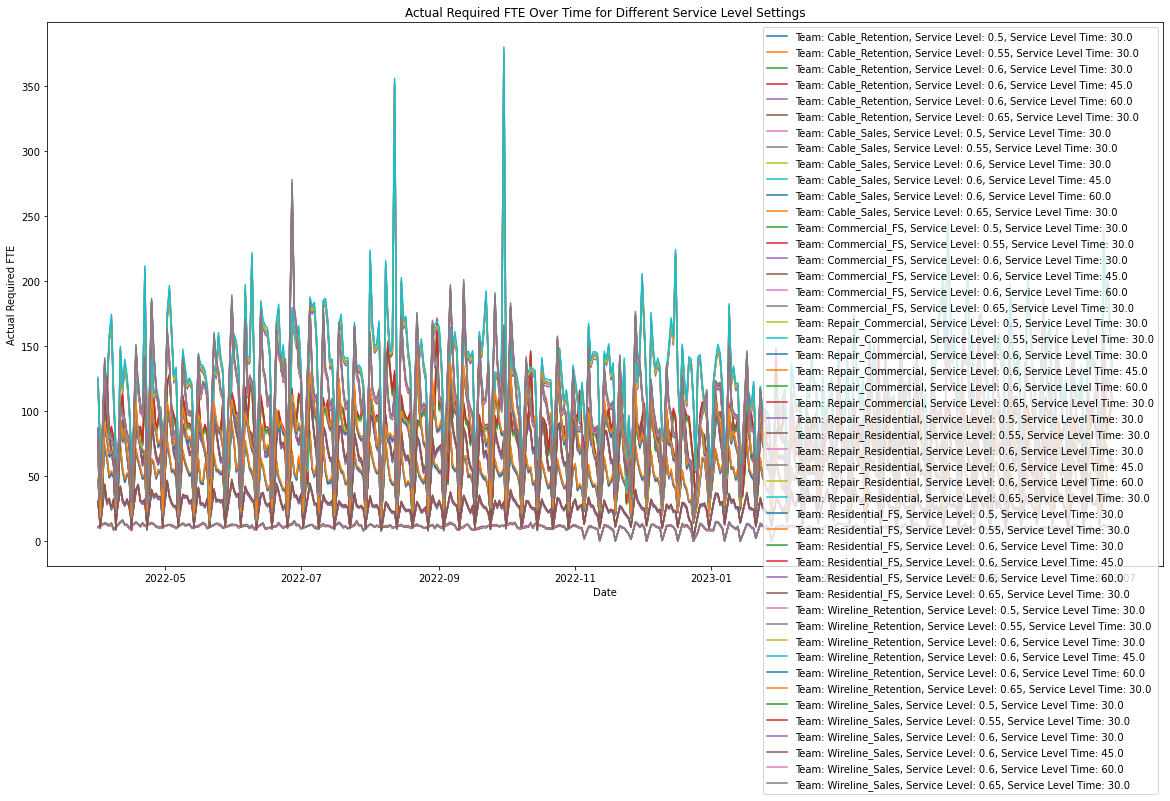

In [13]:
plt.figure(figsize=(20, 10))

# Loop over each unique team
for team in final_results_daily['Team'].unique():
    team_data = final_results_daily[final_results_daily['Team'] == team]

    # Loop over each unique service level and service level time setting
    for setting in team_data[['Service_Level', 'Service_Level_Time']].drop_duplicates().values:
        setting_data = team_data[(team_data['Service_Level'] == setting[0]) & (team_data['Service_Level_Time'] == setting[1])]

        # Plot the actual required FTE for each setting
        plt.plot(setting_data['Date'], setting_data['Actual_Required_FTE'], label=f'Team: {team}, Service Level: {setting[0]}, Service Level Time: {setting[1]}')

plt.title('Actual Required FTE Over Time for Different Service Level Settings')
plt.xlabel('Date')
plt.ylabel('Actual Required FTE')
plt.legend(loc='upper right')
# Save the plot to the 'visualizations' folder
chart_path = os.path.join('visualizations', 'daily_fte_req.png')
plt.savefig(chart_path)

# Display the plot
plt.show()

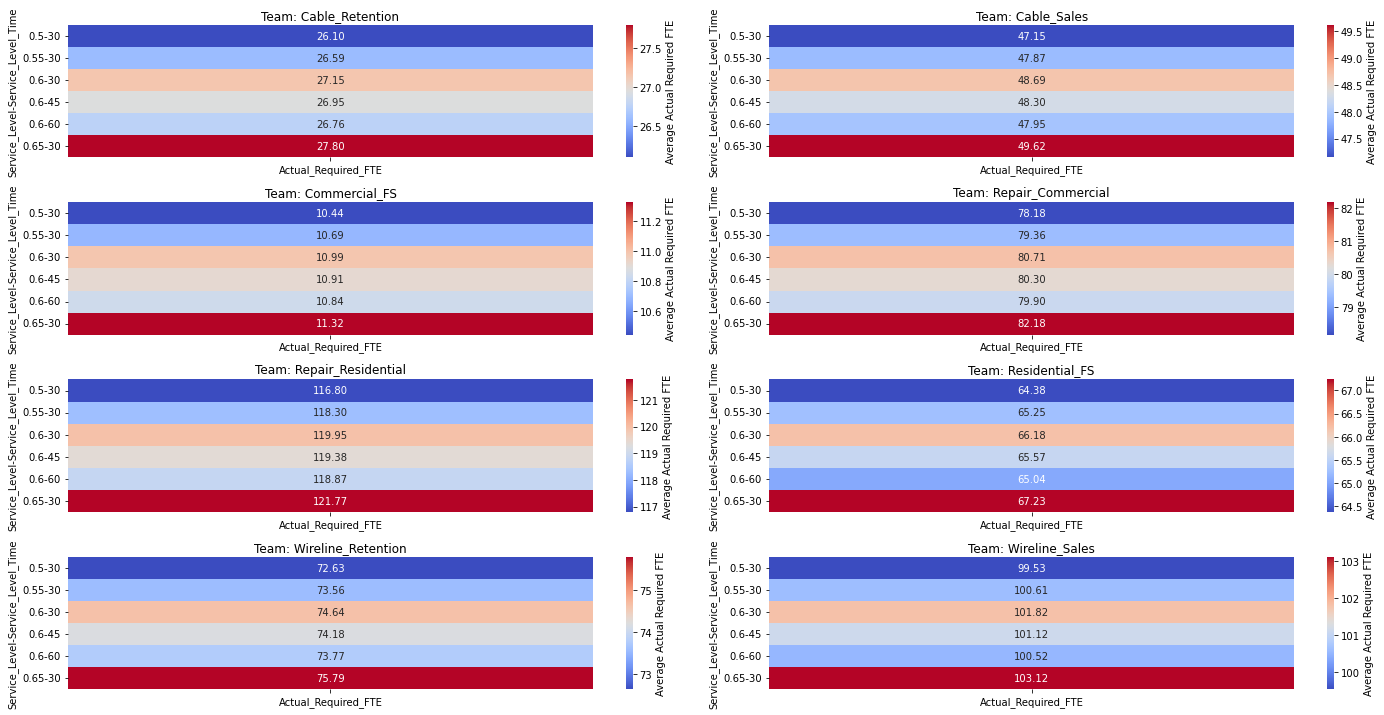

In [14]:
import math

# Get unique teams
teams = final_results_daily['Team'].unique()

# Calculate the layout dimensions for the subplots
cols = 2
rows = math.ceil(len(teams) / cols)

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(20, 10))
axes = axes.ravel()  # Flatten the axes array

# Loop over each unique team
for i, team in enumerate(teams):
    # Filter data for the current team
    team_data = final_results_daily[final_results_daily['Team'] == team]

    # Create a pivot table with the appropriate dimensions
    heatmap_data = team_data.pivot_table(index=['Service_Level', 'Service_Level_Time'], values='Actual_Required_FTE', aggfunc='mean')

    # Create the heatmap
    sns.heatmap(heatmap_data, cmap='coolwarm', ax=axes[i], cbar_kws={'label': 'Average Actual Required FTE'}, annot=True, fmt=".2f")
    axes[i].set_title(f'Team: {team}')

# Remove any unused subplots
for j in range(i+1, rows*cols):
    fig.delaxes(axes[j])

plt.tight_layout()
# Save the plot to the 'visualizations' folder
chart_path = os.path.join('visualizations', 'fte_diff.png')
plt.savefig(chart_path)

# Display the plot
plt.show()


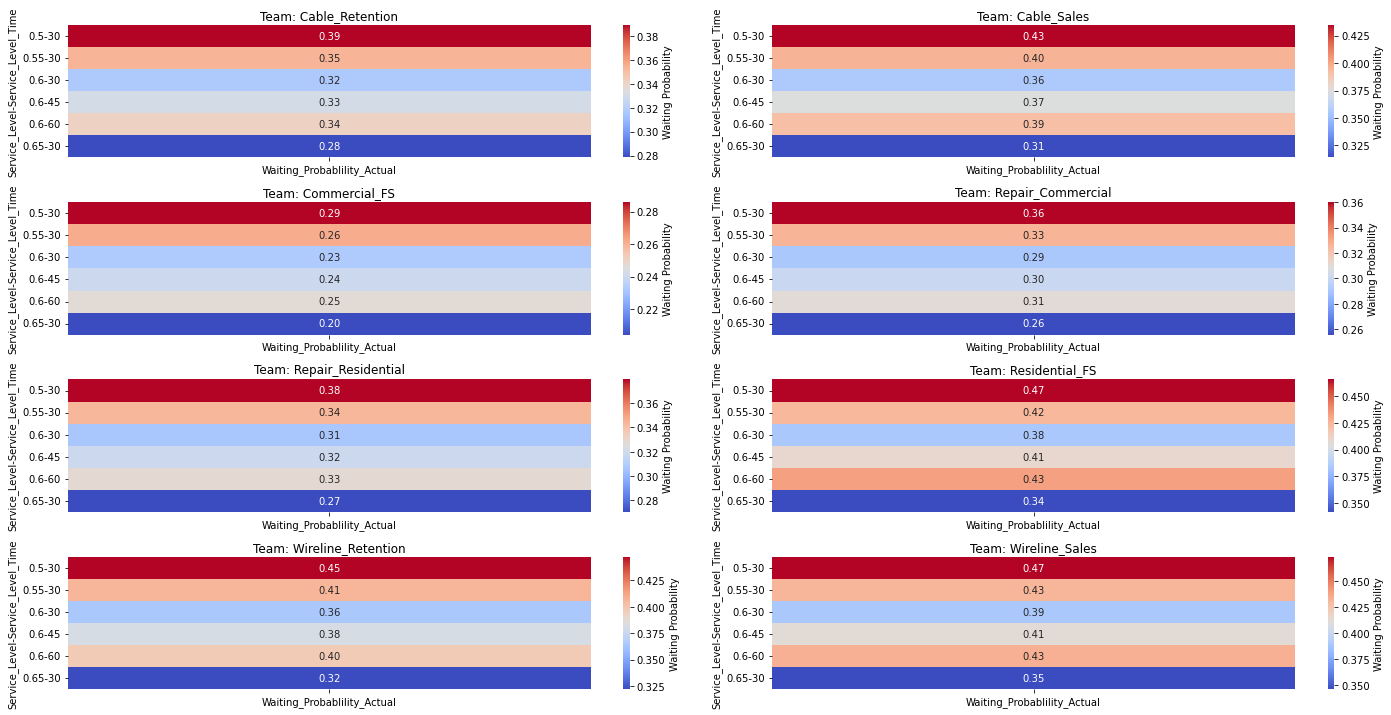

In [31]:
# Get unique teams
teams = final_results['Team'].unique()

# Calculate the layout dimensions for the subplots
cols = 2
rows = math.ceil(len(teams) / cols)

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(20, 10))
axes = axes.ravel()  # Flatten the axes array

# Loop over each unique team
for i, team in enumerate(teams):
    # Filter data for the current team
    team_data = final_results[final_results['Team'] == team]

    # Create a pivot table with the appropriate dimensions
    heatmap_data = team_data.pivot_table(index=['Service_Level', 'Service_Level_Time'], values='Waiting_Probablility_Actual', aggfunc='mean')

    # Create the heatmap
    sns.heatmap(heatmap_data, cmap='coolwarm', ax=axes[i], cbar_kws={'label': 'Waiting Probability'}, annot=True, fmt=".2f")
    axes[i].set_title(f'Team: {team}')

# Remove any unused subplots
for j in range(i+1, rows*cols):
    fig.delaxes(axes[j])

plt.tight_layout()
# Save the plot to the 'visualizations' folder
chart_path = os.path.join('visualizations', 'waiting_prob.png')
plt.savefig(chart_path)

# Display the plot
plt.show()


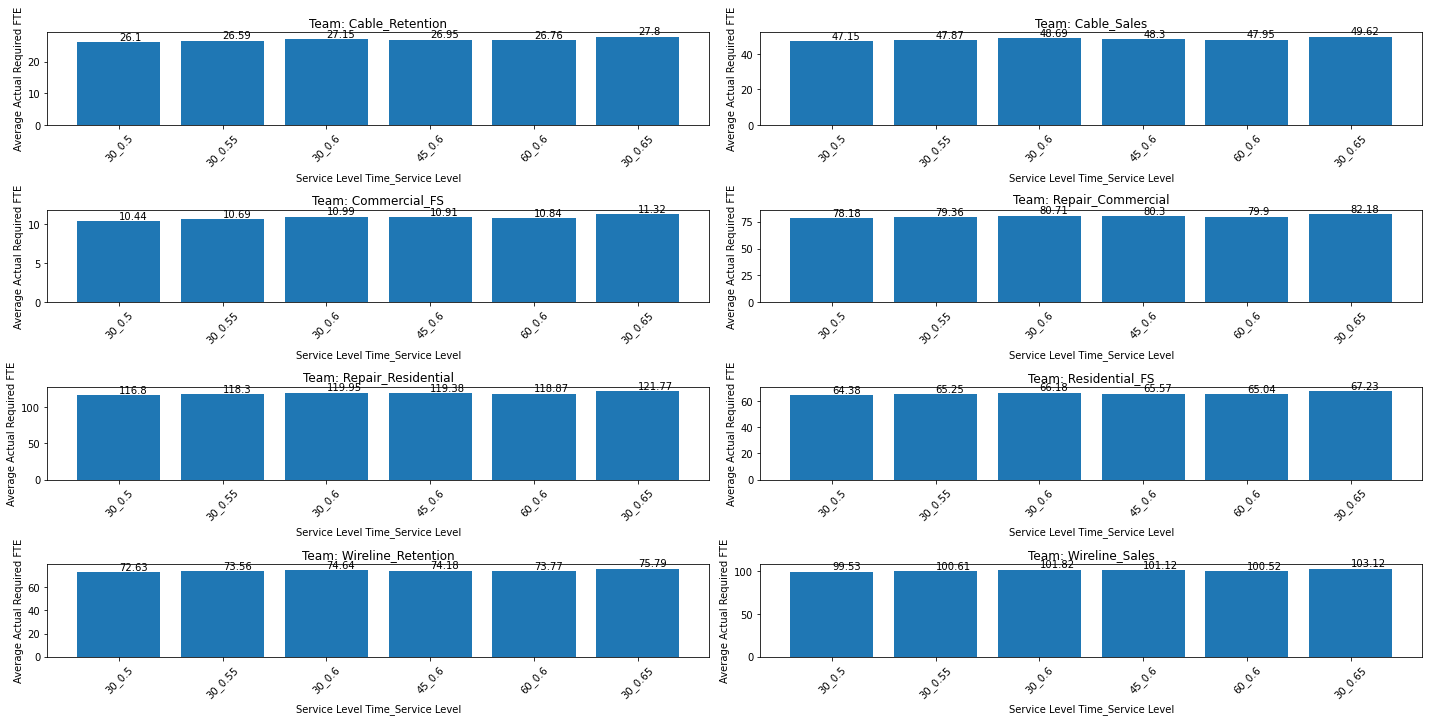

In [15]:
import matplotlib.pyplot as plt

# Preparing the data for bar plot
bar_plot_data = final_results_daily.groupby(['Team', 'Service_Level', 'Service_Level_Time'])['Actual_Required_FTE'].mean().reset_index()

# Calculate the layout dimensions for the subplots
cols = 2
rows = math.ceil(len(teams) / cols)
# Creating bar plots for each team
fig, axes = plt.subplots(rows, cols, figsize=(20, 10))
axes = axes.ravel()  # Flatten the axes array

for i, team in enumerate(teams):
    # Filter data for the current team
    team_data = bar_plot_data[bar_plot_data['Team'] == team]
    
    # Creating bar plot
    bars = axes[i].bar(x=team_data['Service_Level_Time'].astype(str) + "_" + team_data['Service_Level'].astype(str), height=team_data['Actual_Required_FTE'])
    axes[i].set_title(f'Team: {team}')
    axes[i].set_xlabel('Service Level Time_Service Level')
    axes[i].set_ylabel('Average Actual Required FTE')
    axes[i].tick_params(axis='x', rotation=45)

    # Adding FTE values on the bars
    for bar in bars:
        yval = bar.get_height()
        axes[i].text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom')  # Positioned at the top of the bar

# Remove any unused subplots
for j in range(i+1, rows*cols):
    fig.delaxes(axes[j])

plt.tight_layout()
# Save the plot to the 'visualizations' folder
chart_path = os.path.join('visualizations', 'fte_diff_bar.png')
plt.savefig(chart_path)

# Display the plot
plt.show()

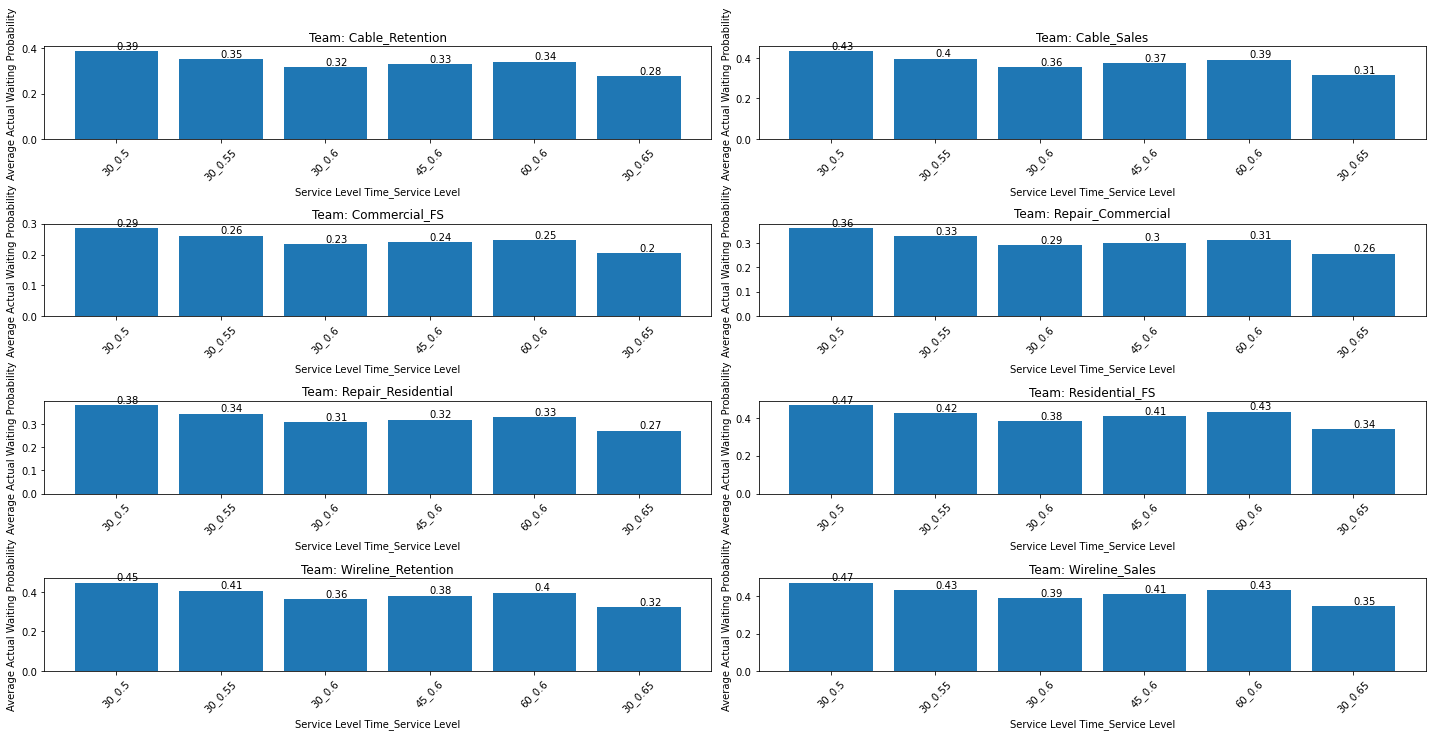

In [32]:
# Preparing the data for bar plot
bar_plot_data = final_results.groupby(['Team', 'Service_Level', 'Service_Level_Time'])['Waiting_Probablility_Actual'].mean().reset_index()

# Calculate the layout dimensions for the subplots
cols = 2
rows = math.ceil(len(teams) / cols)
# Creating bar plots for each team
fig, axes = plt.subplots(rows, cols, figsize=(20, 10))
axes = axes.ravel()  # Flatten the axes array

for i, team in enumerate(teams):
    # Filter data for the current team
    team_data = bar_plot_data[bar_plot_data['Team'] == team]
    
    # Creating bar plot
    bars = axes[i].bar(x=team_data['Service_Level_Time'].astype(str) + "_" + team_data['Service_Level'].astype(str), height=team_data['Waiting_Probablility_Actual'])
    axes[i].set_title(f'Team: {team}')
    axes[i].set_xlabel('Service Level Time_Service Level')
    axes[i].set_ylabel('Average Actual Waiting Probability')
    axes[i].tick_params(axis='x', rotation=45)

    # Adding FTE values on the bars
    for bar in bars:
        yval = bar.get_height()
        axes[i].text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom')  # Positioned at the top of the bar

# Remove any unused subplots
for j in range(i+1, rows*cols):
    fig.delaxes(axes[j])

plt.tight_layout()
# Save the plot to the 'visualizations' folder
chart_path = os.path.join('visualizations', 'waiting_prob_bar.png')
plt.savefig(chart_path)

# Display the plot
plt.show()

In [16]:
# Step 1: Aggregate by Day and Convert to Daily FTE
final_results['Date'] = pd.to_datetime(final_results['Date'])
final_results_weekly = final_results.groupby(['Team', 'Service_Level', 'Service_Level_Time', pd.Grouper(key='Date', freq='W')])['Actual_Required_FTE'].sum().reset_index()
final_results_weekly['Actual_Required_FTE'] = final_results_weekly['Actual_Required_FTE'] / 37.5

In [17]:
import plotly.graph_objects as go

# Create a plot for each team and each setting
fig = go.Figure()

for team in final_results_weekly['Team'].unique():
    team_data = final_results_weekly[final_results_weekly['Team'] == team]

    for setting in team_data[['Service_Level', 'Service_Level_Time']].drop_duplicates().values:
        setting_data = team_data[(team_data['Service_Level'] == setting[0]) & (team_data['Service_Level_Time'] == setting[1])]

        fig.add_trace(go.Scatter(
            x=setting_data['Date'], 
            y=setting_data['Actual_Required_FTE'],
            mode='lines',
            name=f'{team} - Service Level: {setting[0]}, Service Level Time: {setting[1]}',
            legendgroup=team  # Set the same legendgroup for traces belonging to the same team
        ))

fig.update_layout(
    title='Weekly Actual Required FTE Over Time for Different Service Level Settings',
    xaxis_title='Date',
    yaxis_title='Weekly Actual Required FTE',
    autosize=False,
    width=1000,
    height=800,
)
# Save the plot to the 'visualizations' folder
chart_path = os.path.join('visualizations', 'weekly_fte_req.png')
fig.write_image(chart_path)

# Display the plot
plt.show()

### Modified Erlang Function

In [18]:
def process_data_modified(team_settings, team, interval_df, data_type, current_service_level_percent):
    results = []

    for team_info in team_settings:
        service_level_percent, shrinkage, reporting_period, service_level_time = team_info

        for _, row in interval_df.iterrows():
            transactions = row[f'{data_type}_CV']
            aht = row[f'{data_type}_AHT']
            interval = reporting_period
            asa = service_level_time / 60

            if transactions > 0 and aht > 0:
                # Adjust AHT based on the service level percent
                adjusted_aht = aht + 826.43 * (service_level_percent - current_service_level_percent) / 60  # Convert from seconds to minutes
                
                # Ensure adjusted AHT is greater than 0
                adjusted_aht = max(0.01, adjusted_aht)  # Use a small positive number as the lower limit
                
                erlang = ErlangC(transactions=transactions, aht=adjusted_aht, interval=interval, asa=asa, shrinkage=shrinkage)
                
                # Adjust max_occupancy based on the service level percent
                max_occupancy = 1.0 - 0.1586 * (service_level_percent - current_service_level_percent)
                
                # Ensure max_occupancy is within the valid range [0, 1]
                max_occupancy = max(0, min(1, max_occupancy))
                
                positions_requirements = erlang.required_positions(service_level=service_level_percent, max_occupancy=max_occupancy)

                result = {
                    'Team': team,
                    'Date': row['Date'],
                    'Time': row['Time'],
                    'Time_Interval': row['Time_Interval'],
                    'Service_Level': service_level_percent,
                    'Service_Level_Time': service_level_time,
                    f'{data_type}_CV': transactions,
                    f'{data_type}_AHT': aht,
                    f'{data_type}_Required_FTE': positions_requirements['positions'],
                    f'{data_type}_Raw_FTE': positions_requirements['raw_positions'],
                    f'Service_Level_{data_type}': positions_requirements['service_level'],
                    f'Occupancy_{data_type}': positions_requirements['occupancy'],
                    f'Waiting_Probablility_{data_type}': positions_requirements['waiting_probability'],
                }
                results.append(result)

    return pd.DataFrame(results)

In [19]:
# Adjusted call
results = []
# Just an example, replace 0.60 with the actual current service level percent
current_service_level_percent = 0.65

for team, settings in team_settings.items():
    team_df = call_data[call_data['Team'] == team]
    actual_df = process_data_modified(settings, team, team_df, 'Actual', current_service_level_percent)
    forecasted_df = process_data_modified(settings, team, team_df, 'Forecasted', current_service_level_percent)
    result_df = actual_df.merge(forecasted_df, on=['Team', 'Service_Level', 'Service_Level_Time', 'Date', 'Time', 'Time_Interval'], how='outer')
    
    if not result_df.empty:
        results.append(result_df)


final_results_modified = pd.concat(results, ignore_index=True)
final_results_modified.fillna(0, inplace=True)
final_results_modified['Date'] = pd.to_datetime(final_results_modified['Date'], format='%Y-%m-%d')
final_results_modified = final_results_modified.sort_values(by=['Team', 'Service_Level', 'Service_Level_Time', 'Date', 'Time'])

In [20]:
# Step 1: Aggregate by Day and Convert to Daily FTE
final_results_modified['Date'] = pd.to_datetime(final_results_modified['Date'])
final_results_modified_daily = final_results_modified.groupby(['Team', 'Service_Level', 'Service_Level_Time', pd.Grouper(key='Date', freq='D')])['Actual_Required_FTE'].sum().reset_index()
final_results_modified_daily['Actual_Required_FTE'] = final_results_modified_daily['Actual_Required_FTE'] / 7.5

# Step 2: Calculate Differences
final_results_modified_daily = final_results_modified_daily.sort_values(by=['Team', 'Date', 'Service_Level', 'Service_Level_Time'])
final_results_modified_daily['FTE_Difference'] = final_results_modified_daily.groupby(['Team', 'Date'])['Actual_Required_FTE'].diff().fillna(0)

### Modified Erlang Plots

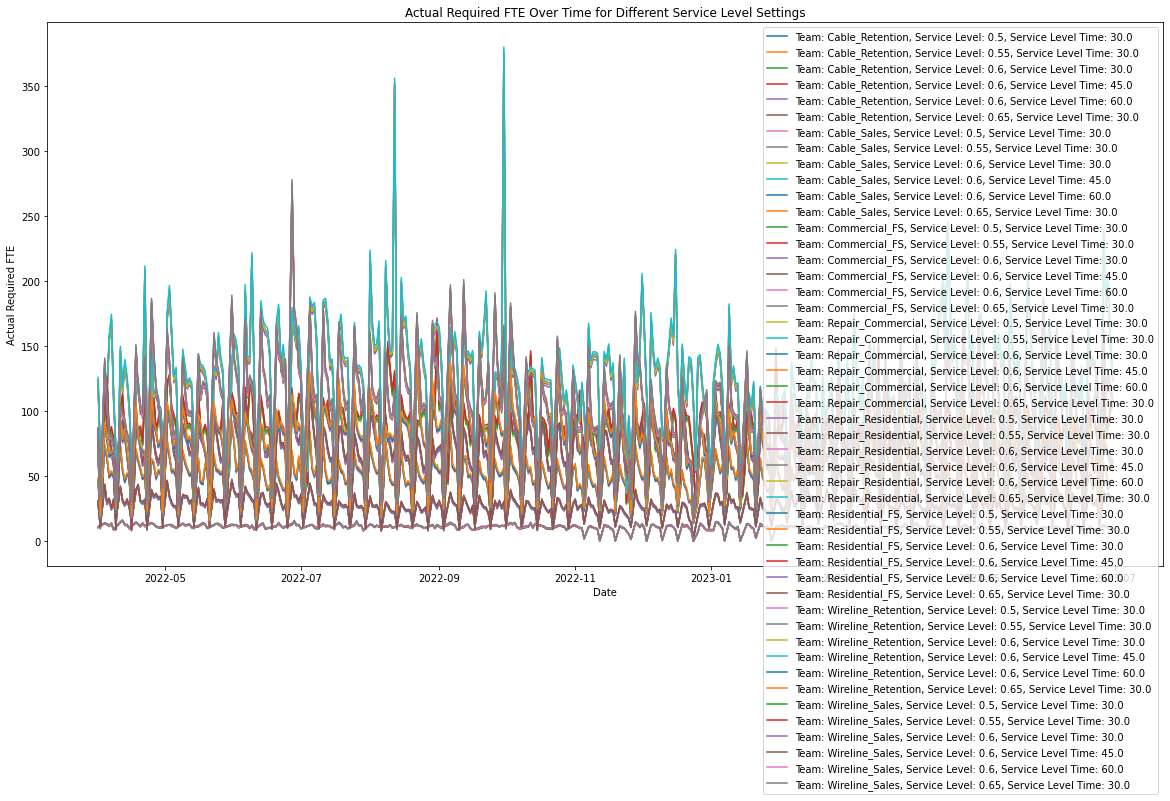

In [21]:
plt.figure(figsize=(20, 10))

# Loop over each unique team
for team in final_results_modified_daily['Team'].unique():
    team_data = final_results_modified_daily[final_results_modified_daily['Team'] == team]

    # Loop over each unique service level and service level time setting
    for setting in team_data[['Service_Level', 'Service_Level_Time']].drop_duplicates().values:
        setting_data = team_data[(team_data['Service_Level'] == setting[0]) & (team_data['Service_Level_Time'] == setting[1])]

        # Plot the actual required FTE for each setting
        plt.plot(setting_data['Date'], setting_data['Actual_Required_FTE'], label=f'Team: {team}, Service Level: {setting[0]}, Service Level Time: {setting[1]}')

plt.title('Actual Required FTE Over Time for Different Service Level Settings')
plt.xlabel('Date')
plt.ylabel('Actual Required FTE')
plt.legend(loc='upper right')
# Save the plot to the 'visualizations' folder
chart_path = os.path.join('visualizations', 'daily_fte_req_modified.png')
fig.write_image(chart_path)

# Display the plot
plt.show()

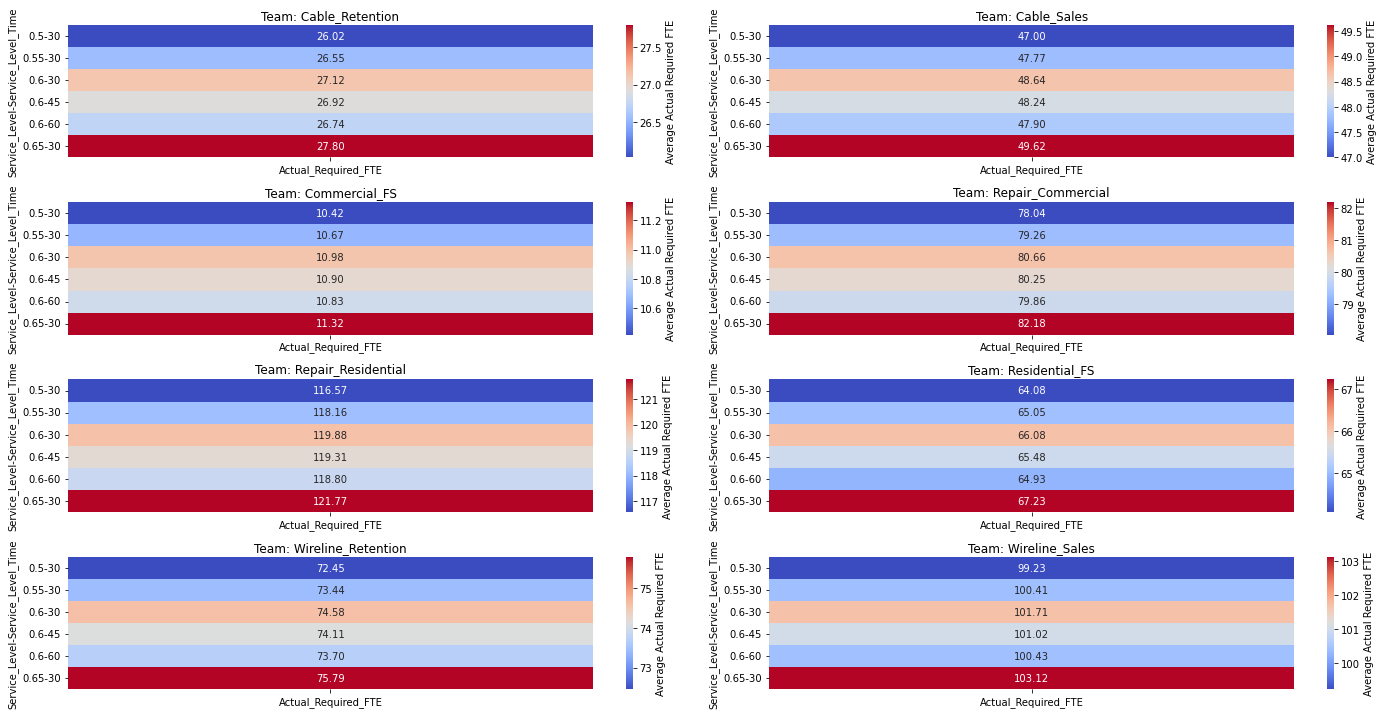

In [22]:
import math

# Get unique teams
teams = final_results_modified_daily['Team'].unique()

# Calculate the layout dimensions for the subplots
cols = 2
rows = math.ceil(len(teams) / cols)

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(20, 10))
axes = axes.ravel()  # Flatten the axes array

# Loop over each unique team
for i, team in enumerate(teams):
    # Filter data for the current team
    team_data = final_results_modified_daily[final_results_modified_daily['Team'] == team]

    # Create a pivot table with the appropriate dimensions
    heatmap_data = team_data.pivot_table(index=['Service_Level', 'Service_Level_Time'], values='Actual_Required_FTE', aggfunc='mean')

    # Create the heatmap
    sns.heatmap(heatmap_data, cmap='coolwarm', ax=axes[i], cbar_kws={'label': 'Average Actual Required FTE'}, annot=True, fmt=".2f")
    axes[i].set_title(f'Team: {team}')

# Remove any unused subplots
for j in range(i+1, rows*cols):
    fig.delaxes(axes[j])

plt.tight_layout()
# Save the plot to the 'visualizations' folder
chart_path = os.path.join('visualizations', 'fte_diff_modified.png')
plt.savefig(chart_path)

# Display the plot
plt.show()

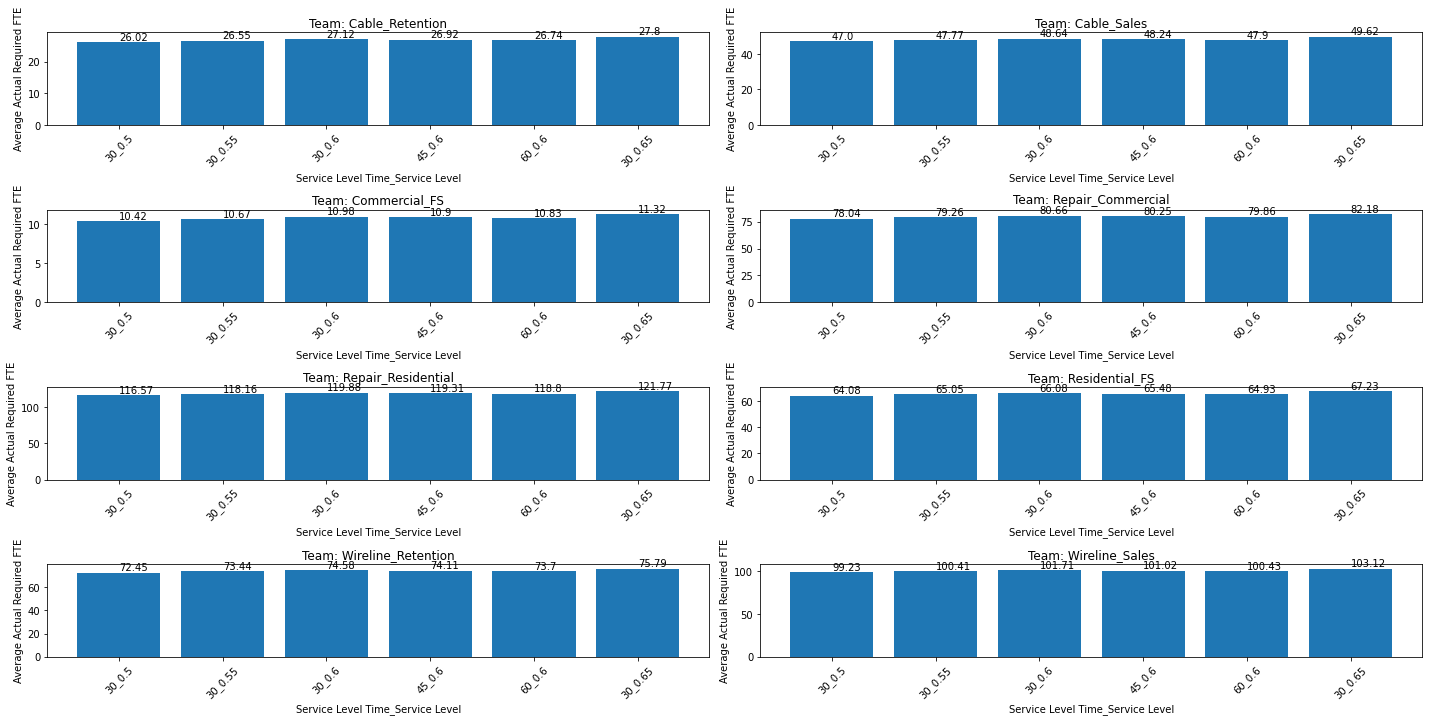

In [23]:
import matplotlib.pyplot as plt

# Preparing the data for bar plot
bar_plot_data = final_results_modified_daily.groupby(['Team', 'Service_Level', 'Service_Level_Time'])['Actual_Required_FTE'].mean().reset_index()

# Calculate the layout dimensions for the subplots
cols = 2
rows = math.ceil(len(teams) / cols)
# Creating bar plots for each team
fig, axes = plt.subplots(rows, cols, figsize=(20, 10))
axes = axes.ravel()  # Flatten the axes array

for i, team in enumerate(teams):
    # Filter data for the current team
    team_data = bar_plot_data[bar_plot_data['Team'] == team]
    
    # Creating bar plot
    bars = axes[i].bar(x=team_data['Service_Level_Time'].astype(str) + "_" + team_data['Service_Level'].astype(str), height=team_data['Actual_Required_FTE'])
    axes[i].set_title(f'Team: {team}')
    axes[i].set_xlabel('Service Level Time_Service Level')
    axes[i].set_ylabel('Average Actual Required FTE')
    axes[i].tick_params(axis='x', rotation=45)

    # Adding FTE values on the bars
    for bar in bars:
        yval = bar.get_height()
        axes[i].text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom')  # Positioned at the top of the bar

# Remove any unused subplots
for j in range(i+1, rows*cols):
    fig.delaxes(axes[j])

plt.tight_layout()
# Save the plot to the 'visualizations' folder
chart_path = os.path.join('visualizations', 'fte_diff_bar_modified.png')
plt.savefig(chart_path)

# Display the plot
plt.show()

In [24]:
# Step 1: Aggregate by Day and Convert to Daily FTE
final_results_modified['Date'] = pd.to_datetime(final_results_modified['Date'])
final_results_modified_weekly = final_results_modified.groupby(['Team', 'Service_Level', 'Service_Level_Time', pd.Grouper(key='Date', freq='W')])['Actual_Required_FTE'].sum().reset_index()
final_results_modified_weekly['Actual_Required_FTE'] = final_results_modified_weekly['Actual_Required_FTE'] / 37.5

In [25]:
final_results_modified_weekly

Team  Service_Level  Service_Level_Time       Date  \
0     Cable_Retention           0.50                  30 2022-04-03   
1     Cable_Retention           0.50                  30 2022-04-10   
2     Cable_Retention           0.50                  30 2022-04-17   
3     Cable_Retention           0.50                  30 2022-04-24   
4     Cable_Retention           0.50                  30 2022-05-01   
...               ...            ...                 ...        ...   
3163   Wireline_Sales           0.65                  30 2023-06-04   
3164   Wireline_Sales           0.65                  30 2023-06-11   
3165   Wireline_Sales           0.65                  30 2023-06-18   
3166   Wireline_Sales           0.65                  30 2023-06-25   
3167   Wireline_Sales           0.65                  30 2023-07-02   

      Actual_Required_FTE  
0                7.973333  
1               34.373333  
2               33.546667  
3               35.706667  
4               36.746667  
...                   ...  
3163           117.680000  
3164           122.160000  
3165           113.973333  
3166           121.546667  
3167           127.493333  

[3168 rows x 5 columns]

In [26]:
import plotly.graph_objects as go

# Create a plot for each team and each setting
fig = go.Figure()

for team in final_results_modified_weekly['Team'].unique():
    team_data = final_results_modified_weekly[final_results_modified_weekly['Team'] == team]

    for setting in team_data[['Service_Level', 'Service_Level_Time']].drop_duplicates().values:
        setting_data = team_data[(team_data['Service_Level'] == setting[0]) & (team_data['Service_Level_Time'] == setting[1])]

        fig.add_trace(go.Scatter(
            x=setting_data['Date'], 
            y=setting_data['Actual_Required_FTE'],
            mode='lines',
            name=f'{team} - Service Level: {setting[0]}, Service Level Time: {setting[1]}',
            legendgroup=team  # Set the same legendgroup for traces belonging to the same team
        ))

fig.update_layout(
    title='Weekly Actual Required FTE Over Time for Different Service Level Settings',
    xaxis_title='Date',
    yaxis_title='Weekly Actual Required FTE',
    autosize=False,
    width=1000,
    height=800,
)

# Save the plot to the 'visualizations' folder
chart_path = os.path.join('visualizations', 'weekly_fte_req_modified.png')
fig.write_image(chart_path)

# Display the plot
fig.show()
